In [1]:
import tensorflow_hub as hub
import numpy as np
import seaborn as sns

In [2]:
# DAN (smaller, faster)
use_dan = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Transformer (larger, typically better)
use_transformer = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [7]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = use_dan(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

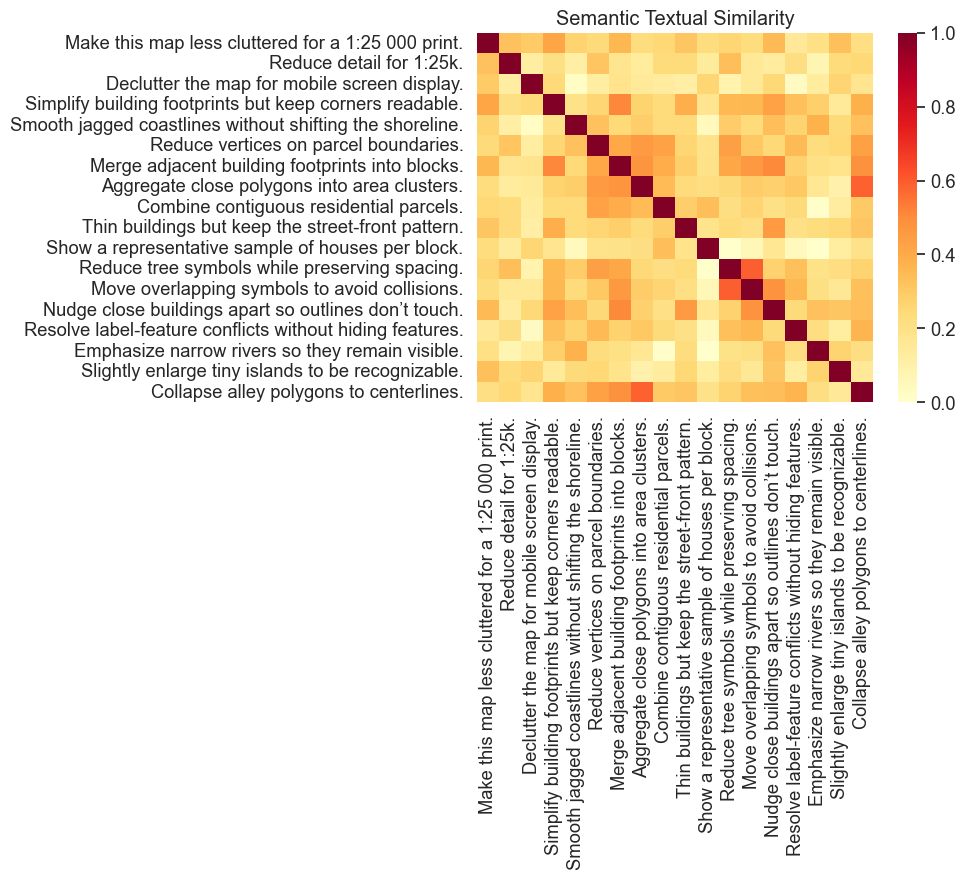

In [8]:
messages = [
    # Decluttering / scale
    "Make this map less cluttered for a 1:25 000 print.",
    "Reduce detail for 1:25k.",
    "Declutter the map for mobile screen display.",

    # Simplification
    "Simplify building footprints but keep corners readable.",
    "Smooth jagged coastlines without shifting the shoreline.",
    "Reduce vertices on parcel boundaries.",

    # Aggregation
    "Merge adjacent building footprints into blocks.",
    "Aggregate close polygons into area clusters.",
    "Combine contiguous residential parcels.",

    # Typification
    "Thin buildings but keep the street-front pattern.",
    "Show a representative sample of houses per block.",
    "Reduce tree symbols while preserving spacing.",

    # Displacement / conflict resolution
    "Move overlapping symbols to avoid collisions.",
    "Nudge close buildings apart so outlines don’t touch.",
    "Resolve label-feature conflicts without hiding features.",

    # Exaggeration / collapse
    "Emphasize narrow rivers so they remain visible.",
    "Slightly enlarge tiny islands to be recognizable.",
    "Collapse alley polygons to centerlines.",
]

run_and_plot(messages)

In [9]:
def embed_text(texts):
    """Return L2-normalized embeddings for a list of strings."""
    E = use_dan(texts).numpy()
    # L2 normalize so cosine = dot product
    E /= np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    return E

# --- 2) Pairwise similarity & top-pair extraction ---
def most_similar_pairs(
    sentences,
    top_k=20,
    drop_identical_strings=True,
):
    """
    Returns a list of tuples: (sent_i, sent_j, similarity) sorted by similarity desc.
    - Removes self-pairs and mirrored duplicates.
    - Optionally removes pairs where the strings are exactly identical.
    """
    n = len(sentences)
    if n < 2:
        return []
    E = embed_text(sentences)  # (n, d) L2-normalized

    # cosine similarity = dot for normalized vectors
    S = np.dot(E, E.T)  # (n, n)

    # collect upper-triangular pairs (i < j) to avoid duplicates/self-pairs
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            if drop_identical_strings and sentences[i].strip() == sentences[j].strip():
                continue
            pairs.append((i, j, float(S[i, j])))

    # sort by similarity
    pairs.sort(key=lambda x: x[2], reverse=True)

    # slice to top_k
    top = pairs[:top_k]

    # return as (sent_i, sent_j, sim)
    return [(sentences[i], sentences[j], sim) for (i, j, sim) in top]

# --- 3) Pretty print helper (optional) ---
def print_top_pairs(pairs, k=10):
    for s1, s2, sim in pairs[:k]:
        print(f"{sim:0.3f} :: \"{s1}\"  ||  \"{s2}\"")

In [10]:
pairs = most_similar_pairs(messages, top_k=25, drop_identical_strings=True)
print_top_pairs(pairs, k=15)

0.593 :: "Reduce tree symbols while preserving spacing."  ||  "Move overlapping symbols to avoid collisions."
0.588 :: "Aggregate close polygons into area clusters."  ||  "Collapse alley polygons to centerlines."
0.509 :: "Simplify building footprints but keep corners readable."  ||  "Merge adjacent building footprints into blocks."
0.506 :: "Merge adjacent building footprints into blocks."  ||  "Nudge close buildings apart so outlines don’t touch."
0.484 :: "Merge adjacent building footprints into blocks."  ||  "Collapse alley polygons to centerlines."
0.477 :: "Move overlapping symbols to avoid collisions."  ||  "Nudge close buildings apart so outlines don’t touch."
0.473 :: "Merge adjacent building footprints into blocks."  ||  "Aggregate close polygons into area clusters."
0.458 :: "Merge adjacent building footprints into blocks."  ||  "Move overlapping symbols to avoid collisions."
0.456 :: "Reduce vertices on parcel boundaries."  ||  "Aggregate close polygons into area clusters."

### Observations on Universal Sentence Encoder Similarities

- The similarity values (0.42–0.59) are cosine similarities between the embeddings.  
  - In practice, sentence similarity in USE usually lives in the **0.2–0.8 range** for unrelated → closely related pairs.  
  - So these results are in the expected interval.  

- The **top pairs actually make semantic sense**:

  - **Symbol conflicts / readability**  
    *“Reduce tree symbols while preserving spacing.”*  
    ↔ *“Move overlapping symbols to avoid collisions.”*  

  - **Geometry aggregation / collapse**  
    *“Aggregate close polygons into area clusters.”*  
    ↔ *“Collapse alley polygons to centerlines.”*  

  - **Building geometry handling**  
    *“Simplify building footprints but keep corners readable.”*  
    ↔ *“Merge adjacent building footprints into blocks.”*  